In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
((train_images, train_labels), (test_images, test_labels)) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
labels = ["T_shirt/top", "Trouser", "Pullover", "Dress",
           "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [5]:
def idx2label(idx):
  return labels[idx]
idx2label(test_labels[0])

'Ankle boot'

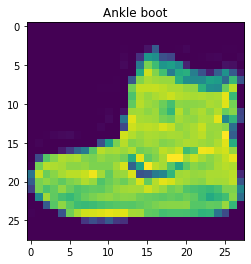

In [6]:
plt.imshow(train_images[0])
plt.title(idx2label(train_labels[0]))
plt.show()

def show(idx):
  plt.imshow(train_images[idx], cmap = "gray")
  plt.title(idx2label(train_labels[idx]))
  plt.show()

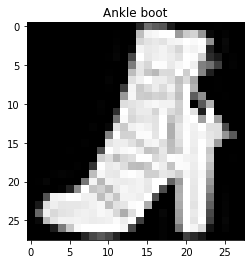

In [7]:
show(11)

In [8]:
train_images.dtype

dtype('uint8')

In [9]:
print(train_images.reshape((60000, -1)).sum(axis = 1).argmax())
print(train_images.reshape((60000, -1)).sum(axis = 1).argmin())

55023
9230


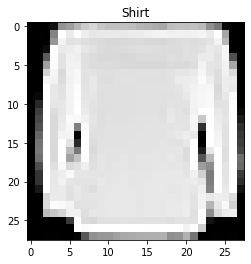

In [10]:
show(55023)

In [11]:
train_images = train_images.astype(np.float64)
test_images = test_images.astype(np.float64)

In [12]:
print(train_images.dtype)
print(test_images.dtype)

float64
float64


In [13]:
def norm(data):
  min_v = data.min()
  max_v = data.max()
  return(data - min_v)/(max_v - min_v)

In [14]:
print(norm(train_images).min())
print(norm(train_images).max())

0.0
1.0


In [15]:
train_images = norm(train_images)
test_images = norm(test_images)

In [16]:
train_images[:5].transpose((1, 0, 2)).reshape((28, -1)).shape

(28, 140)

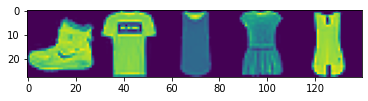

In [17]:
plt.imshow(train_images[:5].transpose((1, 0, 2)).reshape((28, -1)))
plt.show()

In [18]:
np.argwhere(train_labels == 7)[:5, ..., 0]

array([ 6, 14, 41, 46, 52])

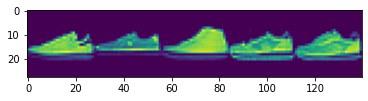

In [19]:
plt.imshow(train_images[np.argwhere(train_labels == 7)[:5, ..., 0]].transpose((1, 0, 2)).reshape((28, -1)))
plt.show()

In [20]:
def filter(label, count = 5):
  imgs = train_images[np.argwhere(train_labels == label)[:count, ..., 0]].transpose((1, 0, 2)).reshape((28, -1))
  plt.imshow(imgs)
  plt.show()

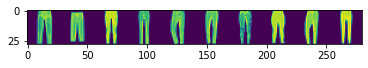

In [21]:
filter(1, 10)

In [22]:
def expand4times(img):
  bg = np.zeros(img.shape)
  idx = np.random.randint(0, 4)

  slots = [bg, bg, bg, bg]
  slots[idx] = img

  expanded = np.vstack([np.hstack(slots[:2]),
                        np.hstack(slots[2:])])
  return expanded

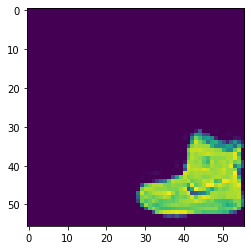

In [23]:
plt.imshow(expand4times(train_images[0]))

In [24]:
train_expand = np.array([expand4times(img) for img in train_images])

In [25]:
def expand4times2(x_data, y_data):
  images = []
  labels = []

  for _ in range(4):
    bg = np.zeros((28, 28))
    obj_count = np.random.randint(0, 5)

    label = np.zeros((10,))
    slots = [bg, bg, bg, bg]

    for idx in range(obj_count):
      i = np.random.randint(len(x_data))
      slots[idx] = x_data[i]
      label += tf.keras.utils.to_categorical(y_data[i], 10)

    np.random.shuffle(slots)
  
  new_img = np.vstack([np.hstack(slots[:2]),
                        np.hstack(slots[2:])])
  images.append(new_img)
  labels.append((label >= 1).astype(np.int))

  return np.array(images), np.array(labels)

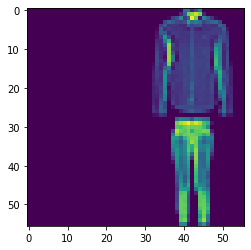

In [26]:
plt.imshow(expand4times2(train_images, train_labels)[0][0])

In [27]:
train_muti_images, train_muti_labels = list(zip(*[expand4times2(train_images, train_labels) for i in train_images]))
test_muti_images, test_muti_labels = list(zip(*[expand4times2(test_images, test_labels) for i in test_images]))

In [30]:
np.array(train_muti_images)[:, 0, :, :].reshape(-1, 56, 56, 1).shape

(60000, 56, 56, 1)

In [33]:
np.array(train_muti_labels)[:, 0, :].shape

(60000, 10)

In [34]:
train_muti_images = np.array(train_muti_images)[:, 0, :, :].reshape(-1, 56, 56, 1)
train_muti_labels = np.array(train_muti_labels)[:, 0, :]
test_muti_images = np.array(test_muti_images)[:, 0, :, :].reshape(-1, 56, 56, 1)
test_muti_labels = np.array(test_muti_labels)[:, 0, :]

In [36]:
print(train_muti_images.shape)
print(train_muti_labels.shape)
print(test_muti_images.shape)
print(test_muti_labels.shape)

(60000, 56, 56, 1)
(60000, 10)
(10000, 56, 56, 1)
(10000, 10)


In [54]:
def filter2(obj_count, count = 5):
  labels = train_muti_labels.sum(axis = 1)
  lds = np.argwhere(labels == obj_count)[:count, 0]

  imgs = train_muti_images[lds][..., 0].transpose((1, 0, 2)).reshape((56, -1))
  plt.imshow(imgs)
  plt.show()

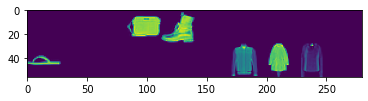

In [55]:
filter2(1, 5)

In [56]:
from keras.layers import Input, Conv2D, Dropout, Dense, Flatten, GlobalAvgPool2D
from keras.models import Model

In [67]:
from keras.layers.pooling import MaxPool2D
def single_fashion_mnist_model():
  inputs = Input((56, 56, 1))
  x = Conv2D(16, 2, padding = 'same', activation = 'relu')(inputs)
  x = MaxPool2D(2)(x)
  x = Dropout(0.3)(x)

  x = Conv2D(32, 2, padding = 'same', activation = 'relu')(x)
  x = MaxPool2D(2)(x)
  x = Dropout(0.3)(x)

  x = Conv2D(64, 2, padding = 'same', activation = 'relu')(x)
  x = MaxPool2D(2)(x)
  x = Flatten()(x)
  x = Dense(10, activation = 'softmax')(x)
  return Model(inputs, x)

In [69]:
def single_fashion_mnist_model2():
  inputs = Input((56, 56, 1))
  x = Conv2D(16, 2, padding = 'same', activation = 'relu')(inputs)
  x = MaxPool2D(2)(x)
  x = Dropout(0.3)(x)

  x = Conv2D(32, 2, padding = 'same', activation = 'relu')(x)
  x = MaxPool2D(2)(x)
  x = Dropout(0.3)(x)

  x = Conv2D(64, 2, padding = 'same', activation = 'relu')(x)
  x = MaxPool2D(2)(x)
  x = GlobalAvgPool2D()(x)
  x = Dense(10, activation = 'softmax')(x)
  return Model(inputs, x)

In [68]:
model = single_fashion_mnist_model()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 56, 56, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 56, 56, 16)        80        
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 28, 28, 16)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 28, 28, 16)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        2080      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                      

In [70]:
model = single_fashion_mnist_model2()
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 56, 56, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 56, 56, 16)        80        
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 28, 28, 16)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 28, 28, 16)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 32)        2080      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                      

In [71]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [76]:
test_expand = np.array([expand4times(img) for img in test_images])

In [79]:
hist = model.fit(train_expand.reshape((-1, 56, 56, 1)),
                 tf.keras.utils.to_categorical(train_labels, 10),
                 validation_data = (test_expand.reshape((-1, 56, 56, 1)), tf.keras.utils.to_categorical(test_labels, 10)),
                 epochs = 15,
                 verbose = 1
)

Epoch 1/15
1875/1875 [==============================] - 31s 11ms/step - loss: 1.3685 - accuracy: 0.5087 - val_loss: 0.9875 - val_accuracy: 0.6549
Epoch 2/15
1875/1875 [==============================] - 22s 12ms/step - loss: 0.9344 - accuracy: 0.6647 - val_loss: 0.8308 - val_accuracy: 0.7005
Epoch 3/15
1875/1875 [==============================] - 23s 12ms/step - loss: 0.8120 - accuracy: 0.7049 - val_loss: 0.7323 - val_accuracy: 0.7391
Epoch 4/15
1875/1875 [==============================] - 21s 11ms/step - loss: 0.7370 - accuracy: 0.7331 - val_loss: 0.6696 - val_accuracy: 0.7586
Epoch 5/15
1875/1875 [==============================] - 21s 11ms/step - loss: 0.6939 - accuracy: 0.7477 - val_loss: 0.6348 - val_accuracy: 0.7759
Epoch 6/15
1875/1875 [==============================] - 22s 12ms/step - loss: 0.6536 - accuracy: 0.7632 - val_loss: 0.6022 - val_accuracy: 0.7904
Epoch 7/15
1875/1875 [==============================] - 21s 11ms/step - loss: 0.6257 - accuracy: 0.7753 - val_loss: 0.5638 -

In [81]:
res = model.predict(test_expand[0].reshape(1, 56, 56, 1))
res.shape

(1, 10)

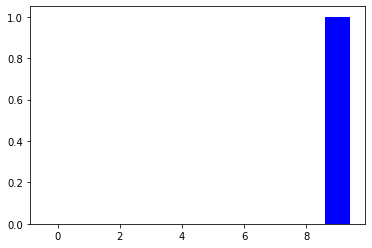

Ankle boot


In [88]:
plt.bar(np.arange(0,10), tf.keras.utils.to_categorical(test_labels[0], 10), color = 'blue')
plt.show()
print(idx2label(test_labels[0]))

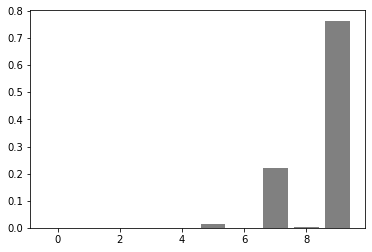

In [89]:
plt.bar(np.arange(0,10), res[0], color = 'gray')
plt.show()

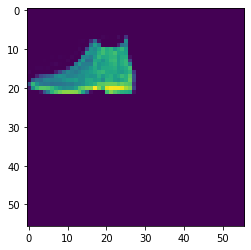

In [90]:
plt.imshow(test_expand[0])

In [99]:
def multi_model(model):
  model.trainable = False
  x = model.layers[-2].output
  x = Dense(10, activation = 'sigmoid')(x)
  return Model(model.input, x)

In [100]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 56, 56, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 56, 56, 16)        80        
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 28, 28, 16)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 28, 28, 16)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 32)        2080      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                      

In [101]:
new_model = multi_model(model)
new_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 56, 56, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 56, 56, 16)        80        
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 28, 28, 16)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 28, 28, 16)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 32)        2080      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                     

In [103]:
new_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [104]:
hist2 = new_model.fit(train_muti_images, train_muti_labels,
                 validation_data = (test_muti_images, test_muti_labels), epochs = 15, verbose = 1)

Epoch 1/15
1875/1875 [==============================] - 14s 7ms/step - loss: 5.1363 - accuracy: 0.1845 - val_loss: 4.3998 - val_accuracy: 0.2329
Epoch 2/15
1875/1875 [==============================] - 13s 7ms/step - loss: 4.3713 - accuracy: 0.2316 - val_loss: 4.1281 - val_accuracy: 0.2691
Epoch 3/15
1875/1875 [==============================] - 15s 8ms/step - loss: 4.1935 - accuracy: 0.2667 - val_loss: 4.0456 - val_accuracy: 0.3172
Epoch 4/15
1875/1875 [==============================] - 13s 7ms/step - loss: 4.1414 - accuracy: 0.2885 - val_loss: 4.0520 - val_accuracy: 0.3038
Epoch 5/15
1875/1875 [==============================] - 13s 7ms/step - loss: 4.1357 - accuracy: 0.3015 - val_loss: 4.1112 - val_accuracy: 0.3260
Epoch 6/15
1875/1875 [==============================] - 15s 8ms/step - loss: 4.1820 - accuracy: 0.3125 - val_loss: 4.1231 - val_accuracy: 0.3439
Epoch 7/15
1875/1875 [==============================] - 13s 7ms/step - loss: 4.2267 - accuracy: 0.3206 - val_loss: 4.0648 - val_ac

In [139]:
res1 = new_model.predict(test_muti_images[0].reshape((1, 56, 56, 1)))
res1.shape

(1, 10)

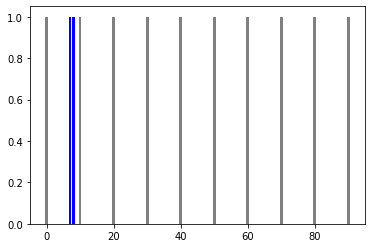

In [152]:
plt.bar(np.arange(0,10), test_muti_labels[0], color = 'blue')
plt.bar(np.arange(0,10)*10, res1[0], color = 'gray')

plt.show()

In [108]:
epochs = 15
batch_size = 32
new_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
for epoch in range(epochs):
  for _ in range(0, len(train_images), batch_size):
    batch_x = []
    batch_y = []

    for _ in range(batch_size):
      x, y = expand4times2(train_images, train_labels)
      batch_x.append(x)
      batch_y.append(y)

    batch_x = np.array(batch_x).reshape((-1, 56, 56, 1))
    batch_y = np.array(batch_y).reshape((-1, 10))
    new_model.train_on_batch(batch_x, batch_y)
  print(epoch, 'e')

0 e
1 e
2 e
3 e
4 e
5 e
6 e
7 e
8 e
9 e
10 e
11 e
12 e
13 e
14 e


In [149]:
res = new_model.predict(test_muti_images[0].reshape((1, 56, 56, 1)))
res.shape

(1, 10)

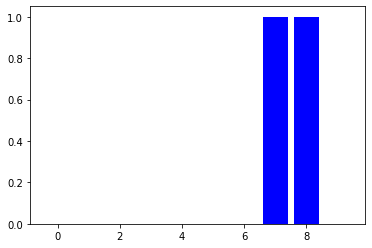

In [150]:
plt.bar(np.arange(0,10), test_muti_labels[0], color = 'blue')
plt.show()

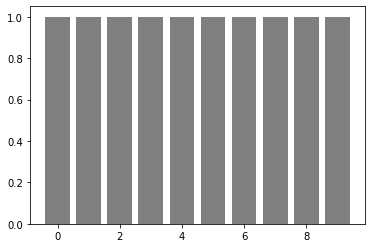

In [151]:
plt.bar(np.arange(0,10), res[0], color = 'gray')
plt.show()